### Solves convection-diffusion equation using MOLE

In [1]:
import numpy as np
import scipy.sparse as sp
from core import *

In [18]:
import matplotlib.pyplot as plt
from matplotlib import animation, rcParams
from IPython.display import HTML

In [24]:
plt.rcParams['animation.html'] = 'html5'

In [4]:
#  Mimetic operator's parameters
k = 2
m = 101
n = 51
o = 101

#  Domain's dimensions
a = 0
b = 101
c = 0
d = 51
e = 0
f = 101

#  Spatial step sizes
dx = (b - a) / m
dy = (d - c) / n
dz = (f - e) / o

#  Mimetic operators
D = div3D(k, m, dx, n, dy, o, dz)
G = grad3D(k, m, dx, n, dy, o, dz)
I = interpol3D(m, n, o, 1, 1, 1)

#  Pore velocity vector
V = np.zeros(G.shape[0])

#  Density vector
C = np.zeros((m+2, n+2, o+2))

#  Impose initial conditions
bottom = 10  #  Well
top = 15     #  Well
seal = 40    #  Shale

#  Velocity field
y = np.ones((m, n+1, o))
y[:, seal, :] = 0
y[:, seal+5, :] = 0

#  Shale
V[((m+1)*n*o):((m+1)*n*o + y.size)] = y.flatten()

#  Density
C[int((m+2)/2), bottom:top, int((o+2)/2)] = 1.  #  ceil((o+2)/2)
C = C.flatten()
idx = np.nonzero(C)

#  Diffusivity and porosity -----------------------------------------------
#  CO2 molecular diffusivity at: 45°C, S = 35, and P = 75atm
diff = 1.                #  [m^2/s]
porosity = 1.            #  Sandstone -> 30%
diff = diff * porosity

K = diff * np.ones(G.shape[0])
kk = diff * np.ones((m, n+1, o))
kk[:, seal, :] = diff / 10.
kk[:, seal+5, :] = diff / 40.
K[((m+1)*n*o):((m+1)*n*o + kk.size)] = kk.flatten()  #  Shale
#  ------------------------------------------------------------------------

#  dt based on von Neumann criterion
dt1 = dx**2 / (3. * diff) / 3.
#  dt based on CFL condition
dt2 = (dx / np.amax(V)) / 3.
#  Select minimum dt
dt = np.amin([dt1, dt2])

iters = 120  #  90 = 30s  if dt = 0.3333 because CFL

#  Premultiplication of Laplacian operator
L = dt * np.dot(D, np.dot(sp.spdiags(K, 0, K.size, K.size), G))
L = L + sp.eye(L.shape[0], L.shape[1])

#  Premultiplication of Divergence operator
D = dt * np.dot(D, np.dot(sp.spdiags(V, 0, V.size, V.size), I))

c_disp = np.zeros((m+2, n+2, o+2, iters * 3))

for i in range(iters * 3):
    #  Solve diffusive term using FTCS scheme
    C = L @ C
    #  Impose wellbore conditions
    C[idx] = 1.
    #  Solve advective term using upwind scheme
    C = C - D @ C
    #  Impose wellbore conditions
    C[idx] = 1.
    
    c_disp[..., i] = np.reshape(C, (m+2, n+2, o+2))

/Users/nutrik/Documents/Science/scodes/Python/mole/core/div3D.py:26: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  Im[1:m+1, :] = sparse.eye(m, m, dtype=np.float, format='csr')
/Users/nutrik/Documents/Science/scodes/Python/mole/core/div3D.py:27: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  In[1:n+1, :] = sparse.eye(n, n, dtype=np.float, format='csr')
/Users/nutrik/Documents/Science/scodes/Python/mole/core/div3D.py:28: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  Io[1:o+1, :] = sparse.eye(o, o, dtype=np.float, format='csr')
/Users/nutrik/Documents/Science/scodes/Python/mole/core/div.py:46: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  D[i, j:j+k] = coeffs
/Users/nutrik/Documents/Science/scodes/Pyth

In [5]:
c_disp.shape

(103, 53, 103, 360)

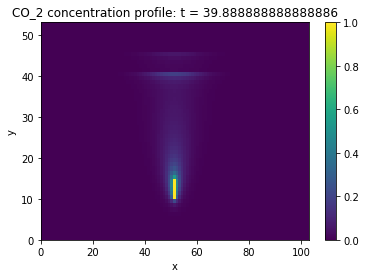

In [26]:
p = 359 #  Page to be displayed
page = c_disp[int((m+2)/2), :, :, p]
#page = c_disp[int((m+2)/2), seal, int((o+2)/2), p]

cs = plt.pcolor(page, vmin=0, vmax=1)
plt.colorbar(cs)
plt.title('CO_2 concentration profile: t = {}'.format(i * dt))
plt.xlabel('x')
plt.ylabel('y');

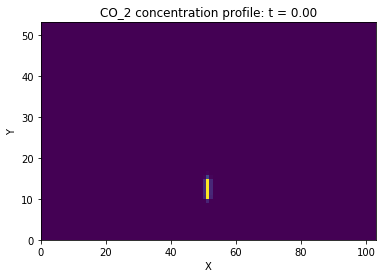

In [31]:
# Attaching 3D axis to the figure
fig = plt.figure()
ax = fig.add_subplot(111)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')

surface = [ax.pcolor(c_disp[int((m+2)/2), :, :, 0], cmap="viridis", vmin=0, vmax=1)]

def update_plot(frame_number, data, surface):
    ax.set_title('CO_2 concentration profile: t = {:03.2f}'.format(frame_number * dt))
    surface[0] = ax.pcolor(data[int((m+2)/2), :, :, frame_number], cmap="viridis", vmin=0, vmax=1)

anim = animation.FuncAnimation(fig, update_plot, frames=(iters * 3), fargs=(c_disp, surface), interval=50)

In [32]:
anim